# Classification task
## In this lab we will examine the `Weekly` data, which is part of the `ISLP` package. For this project we will explore various classification models such as `logistic regression`, `linear discriminant analysis`, `Quadratic discriminant analysis`, `naive bayes`, and `K-nearest neighbors` to determine which model is most suitable for the data set used.
### **1. Importing libraries and loading data**

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize)
from ISLP import confusion_table
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA, 
                                           QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [145]:
weekly_returns = load_data('Weekly')
weekly_returns.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


In [146]:
weekly_returns.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000
mean,2000.048669,0.150585,0.151079,0.147205,0.145818,0.139893,1.574618,0.149899
std,6.033182,2.357013,2.357254,2.360502,2.360279,2.361285,1.686636,2.356927
min,1990.000000,-18.195000,-18.195000,-18.195000,-18.195000,-18.195000,0.087465,-18.195000
25%,1995.000000,-1.154000,-1.154000,-1.158000,-1.158000,-1.166000,0.332022,-1.154000
50%,2000.000000,0.241000,0.241000,0.241000,0.238000,0.234000,1.002680,0.241000
75%,2005.000000,1.405000,1.409000,1.409000,1.409000,1.405000,2.053727,1.405000
max,2010.000000,12.026000,12.026000,12.026000,12.026000,12.026000,9.328214,12.026000


### This data set consists of weekly percentage returns for stock index over 21 years, from 1990 until 2010. Each date contains the percentage returns for each of the five previous trading days, `Lag1` through `Lag5`. We have also recorded  `Volume` (the number of shares traded on the previous day, in billions), `Today` (the percentage return on the date in question) and  `Direction` (whether the market was  `Up`  or  `Down`  on this date).
### **2. Exploratory visualisation**

In [164]:
# Correlation matrix
weekly_returns.corr()

C:\Users\Dolf\AppData\Local\Temp\ipykernel_20132\765845474.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  weekly_returns.corr()


,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,-0.032289,-0.033390,-0.030006,-0.031128,-0.030519,0.841942,-0.032460
Lag1,-0.032289,1.000000,-0.074853,0.058636,-0.071274,-0.008183,-0.064951,-0.075032
Lag2,-0.033390,-0.074853,1.000000,-0.075721,0.058382,-0.072499,-0.085513,0.059167
Lag3,-0.030006,0.058636,-0.075721,1.000000,-0.075396,0.060657,-0.069288,-0.071244
Lag4,-0.031128,-0.071274,0.058382,-0.075396,1.000000,-0.075675,-0.061075,-0.007826
Lag5,-0.030519,-0.008183,-0.072499,0.060657,-0.075675,1.000000,-0.058517,0.011013
Volume,0.841942,-0.064951,-0.085513,-0.069288,-0.061075,-0.058517,1.000000,-0.033078
Today,-0.032460,-0.075032,0.059167,-0.071244,-0.007826,0.011013,-0.033078,1.000000


([<matplotlib.axis.XTick at 0x190830a2d00>,
 [Text(1990, 0, '1990'),
  Text(1995, 0, '1995'),
  Text(2000, 0, '2000'),
  Text(2005, 0, '2005'),
  Text(2010, 0, '2010')])

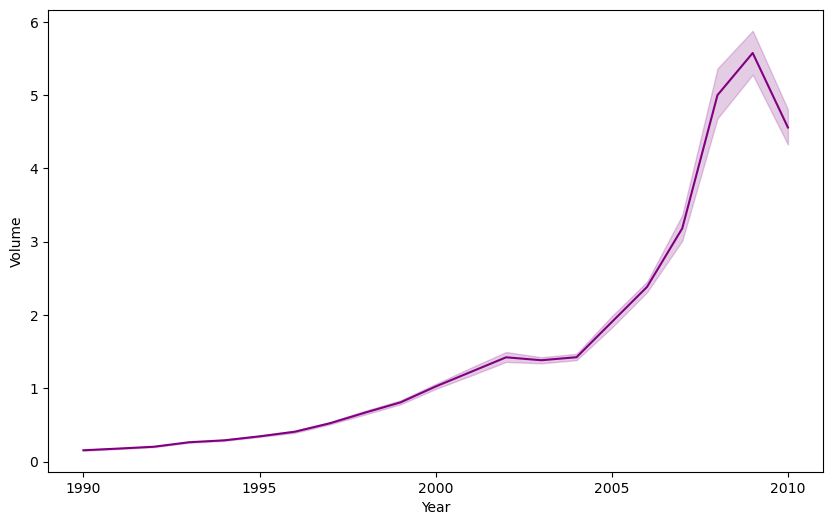

In [147]:
# Time-series plot
plt.figure(figsize=(10,6))
sns.lineplot(y= weekly_returns['Volume'], x= weekly_returns['Year'], color= 'purple')
x_ticks = weekly_returns['Year'].unique()[::5]  # Get unique years with 5 increments
plt.xticks(x_ticks)

<Axes: xlabel='Volume', ylabel='Direction'>

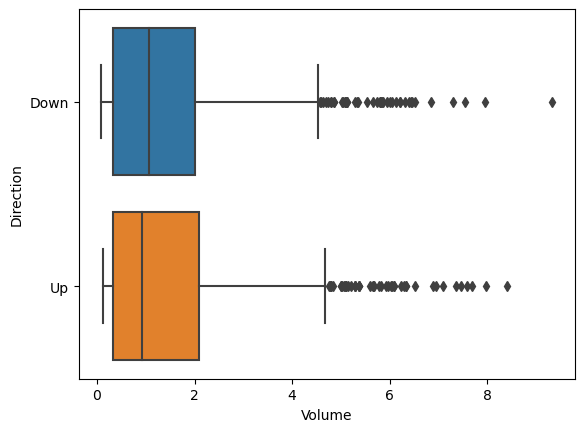

In [148]:
sns.boxplot(x= weekly_returns['Volume'], y= weekly_returns['Direction'])

### The correlation matrix shows a very strong positive correlation between `Volume` and `Year` which is further shown using a line plot for a `time-series analysis` on the volume traded during this period. We observe an increase in volume traded over the years. There is a spike towards 2005 reaching a peak in 2009. Meaning the most shares were traded in this period.
### Another high correlation is between `Volume` and `Lag2`, showing a very strong negative relationship.
### Comparing the medians of the boxplots we observe that slightly more stocks were sold than bought.
### Next, I will perform a `logistic regression` to the full data set using `Direction` as the target and `Lag1` to `Lag5` and `Volume` as the predictors. The results of this regression will help determine statistical significance in our predictors in relation to our target.
### **3. Classification models**
### **Logistic regression** 

In [149]:
# Predictors and response
predictors = list(weekly_returns.drop(columns= ['Year', 'Today', 'Direction']))
y = weekly_returns['Direction'].map({'Down':0, 'Up':1}) # transforming response into binary to avoid dummy variables
X = MS(predictors).fit_transform(weekly_returns)

# Logistics regression
logreg = sm.Logit(y, X)
rslt = logreg.fit()
rslt.summary()

Optimization terminated successfully.
         Current function value: 0.682441
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Direction   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1082
Method:                           MLE   Df Model:                            6
Date:                Sat, 19 Aug 2023   Pseudo R-squ.:                0.006580
Time:                        15:19:55   Log-Likelihood:                -743.18
converged:                       True   LL-Null:                       -748.10
Covariance Type:            nonrobust   LLR p-value:                    0.1313
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2669      0.086      3.106      0.002       0.098       0.435
Lag1          -0.0413      0.026     -1.563      0.118      -0.093       0.010
Lag2           0.0584      0.027      2.175      0.030       0.006       0.111
Lag3          -0.0161      0.027     -0.602      0.547      -0.068       0.036
Lag4          -0.0278      0.026     -1.050      0.294      -0.080       0.024
Lag5          -0.0145      0.026     -0.549      0.583      -0.066       0.037
Volume        -0.0227      0.037     -0.616      0.538      -0.095       0.050
==============================================================================
"""

### Using a p-value of less than 0.05 as our criteria to determine statistical significance, we can drop every other predictor except for `Lag2`. This can be expected as we observed a very strong correlation between `Lag2` and `Volume` earlier with the correlation matrix.
### Using a confusion matrix, I will determine the performance of the logistic regression.

In [150]:
y_pred = rslt.predict(X) >= 0.5
cm = confusion_matrix(y, y_pred)
accuracy = accuracy_score(y, y_pred)
print('Confusion matrix:')
print(cm , '\n')
print('Accuracy: {:.2f}'.format(accuracy * 100)) 

Confusion matrix:
[[ 54 430]
 [ 48 557]] 

Accuracy: 56.11


### The results show a 56.11% accuracy, which is not bad for stock market direction prediction. The model predicted the market to go down correctly 54 times (True negative), and to go up correctly 557 times (True positive). 
### The model does however incorrectly predict the market to go down 430 times (False negative), and incorreclty predict the market to go up 48 times (false positive). This information can be used to guide a trading strategy although it is important to note that the stock market does have a lot of complexities, other factors could be studies and applied.
### In order to truly test the performance of the model, I will use data from 2009 - 2010 as the test set and data from 1990 - 2008 as the training set. The significance of a model is based on its performance on unseen data.
### For the improved model, we only use `Lag2` as it is the only predictor that is statistically significant. This will be used to test different models including a `linear discriminant analysis`, `Quadratic discriminant analysis`, the `naive bayes` and `K-nearest neighbors`.

In [151]:
# Assigning training and test sets
# Train set for data from 1990 - 2008
X_train = weekly_returns[weekly_returns['Year'] <= 2008]['Lag2']
X_train = sm.add_constant(X_train)
y_train = weekly_returns[weekly_returns['Year'] <= 2008]['Direction'].map({'Down':0, 'Up':1})

# Test set for data from 2009 - 2010
X_test = weekly_returns[weekly_returns['Year'] > 2008]['Lag2']
X_test = sm.add_constant(X_test)
y_test = weekly_returns[weekly_returns['Year'] > 2008]['Direction'].map({'Down':0, 'Up':1})

X_train.head(), y_train.head()

(   const   Lag2
 0    1.0  1.572
 1    1.0  0.816
 2    1.0 -0.270
 3    1.0 -2.576
 4    1.0  3.514,
 0    0
 1    0
 2    1
 3    1
 4    1
 Name: Direction, dtype: int64)

In [166]:
# Logistics regression
logreg1 = sm.Logit(y_train, X_train)
rslt1 = logreg1.fit()

# Confusion matrix
y_pred1 = rslt1.predict(X_test) >= 0.5
cm1 = confusion_matrix(y_test, y_pred1)
accuracy1 = accuracy_score(y_test, y_pred1)

print('Confusion matrix:')
print(cm1 , '\n')
print('Accuracy: {:.2f}'.format(accuracy1 * 100)) 

Optimization terminated successfully.
         Current function value: 0.685555
         Iterations 4
Confusion matrix:
[[ 9 34]
 [ 5 56]] 

Accuracy: 62.50


### Using only `Lag2` as the predictor, the performance of our logistic regression has improved from 56.11% to 62.5% accuracy.
### **Linear discriminant analysis**

In [155]:
# Linear discriminant analysis
lda = LDA()
lda = lda.fit(X_train, y_train)

# Confusion matrix
lda_pred = lda.predict(X_test)
lda_cm = confusion_matrix(y_test, lda_pred)
lda_accuracy = accuracy_score(y_test, lda_pred)

print('Confusion matrix:')
print(lda_cm , '\n')
print('Accuracy: {:.2f}'.format(lda_accuracy * 100)) 

Confusion matrix:
[[ 9 34]
 [ 5 56]] 

Accuracy: 62.50


### Using a linear discriminant analysis we achieve 62.5% accuracy, which is similar to the logistics regression.
### **Quadratic discriminant analysis**

In [156]:
# Quadratic discriminant analysis
qda = QDA()
qda = qda.fit(X_train, y_train)

# Confusion matrix
qda_pred = qda.predict(X_test)
qda_cm = confusion_matrix(y_test, qda_pred)
qda_accuracy = accuracy_score(y_test, qda_pred)

print('Confusion matrix:')
print(qda_cm , '\n')
print('Accuracy: {:.2f}'.format(qda_accuracy * 100)) 

Confusion matrix:
[[43  0]
 [61  0]] 

Accuracy: 41.35


c:\Users\Dolf\miniconda3\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\Dolf\miniconda3\lib\site-packages\sklearn\discriminant_analysis.py:951: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
c:\Users\Dolf\miniconda3\lib\site-packages\sklearn\discriminant_analysis.py:951: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
c:\Users\Dolf\miniconda3\lib\site-packages\sklearn\discriminant_analysis.py:954: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])


### Using a quadratic discriminant analysis the model performs much poorly only attaining 41.53% accuracy.
### **Naive bayes**

In [162]:
# Naive bayes
nb = GaussianNB()
nb = nb.fit(X_train, y_train)

# Confusion matrix
nb_pred = nb.predict(X_test)
nb_cm = confusion_matrix(y_test, nb_pred)
nb_accuracy = accuracy_score(y_test, nb_pred)

print('Confusion matrix:')
print(nb_cm , '\n')
print('Accuracy: {:.2f}'.format(nb_accuracy * 100)) 

Confusion matrix:
[[ 0 43]
 [ 0 61]] 

Accuracy: 58.65


### The naive bayes attains an accuracy of 58.65% lower than logistics regression and linear discriminant analysis but much better than a quadratic discriminant analysis.
### **K-nearest neighbours**

In [163]:
# K-nearest neighbour
knn = KNeighborsClassifier(n_neighbors= 3)
knn = knn.fit(X_train, y_train)

# Confusion matrix
knn_pred = knn.predict(X_test)
knn_cm = confusion_matrix(y_test, knn_pred)
knn_accuracy = accuracy_score(y_test, knn_pred)

print('Confusion matrix:')
print(knn_cm , '\n')
print('Accuracy: {:.2f}'.format(knn_accuracy * 100)) 

Confusion matrix:
[[16 27]
 [20 41]] 

Accuracy: 54.81


### The k-nearest neighbour attains an accuracy of 54.81%.
### **Conclusion**
### Comparing all our methods, the best results for predicting the direction of the stock index are obtained using either the logistics regression or linear discriminant analysis as they both have the same accuracy of 62.5% which is higher than quadratic discriminant analysis (41.35%) and the k-nearest neighbour (54.8%).
### Logistics regression and linear discriminant analysis are best for modelling linear relationships whereas quadratic discriminant analysis and the k-nearest neighbour are more suitable for non-linear/complex relationships.